In [1]:
from pathlib import Path

from lightning.pytorch import Trainer

from eotorch.data import (
    SegmentationDataModule,
    SemanticSegmentationTask,
    get_segmentation_dataset,
)
from eotorch.plot import plot_samples
from eotorch.processing import normalize

class_mapping = {
    1: "Baresoil",
    2: "Buildings",
    3: "Coniferous Trees",
    4: "Deciduous Trees",
    5: "Grass",
    6: "Impervious",
    7: "Water",
}

DATASET_DIR = Path.cwd().parent / ("dev_data")
IMG_DIR = DATASET_DIR / "sr_data"
LABEL_DIR = DATASET_DIR / "labels"

NORM_DIR = DATASET_DIR / "normalized"

assert Path(IMG_DIR).is_dir()
assert Path(LABEL_DIR).is_dir()

### Normalization and other preprocessing

In [ ]:
for f in IMG_DIR.rglob("*.tif"):
    print(f)
    out_file = NORM_DIR / f.parent.name / f.name
    out_file.parent.mkdir(exist_ok=True, parents=True)
    out_path = normalize(
        img_path=f, limits=(0.1, 99.5), out_path=out_file, sample_size=0.2
    )

### Create a segmentation dataset and visualize some samples

The function to create the dataset can create different datasets based on which parameters you pass. E.g. you can either provide a label directory or not. For training, you obviously want labels, but there are cases where you might want a compatible dataset without labels.

If your dataset has a temporal component, you can match the relevant image and label files to each other via their file names by setting certain parameters. For example:

```python
image_filename_regex=r'.*_(?P<date>\d{4})_.*',
label_filename_regex=r'.*_(?P<date>\d{4})_.*',
date_format="%Y",
```
would use the provided regex to extract the dates from the filenames and then interpret those date as years

Use the 'plot_samples' function to sample some random patches from your dataset. You can set 'show_filepaths' to True in order to validate that the image files are matched with the correct label files. 

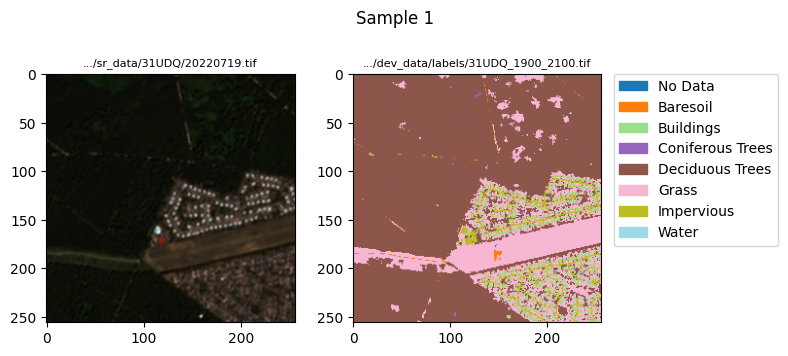

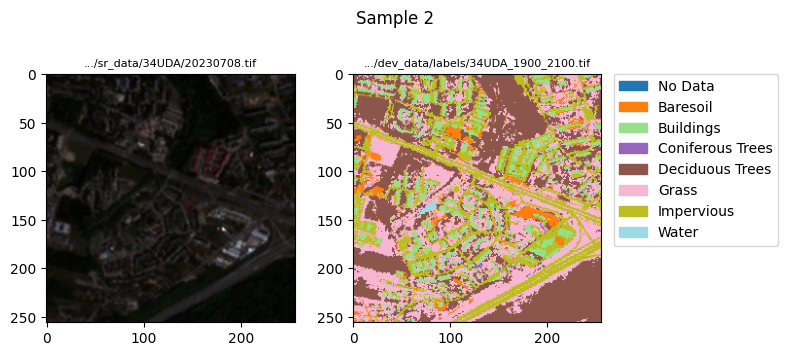

In [2]:
ds = get_segmentation_dataset(
    images_dir=IMG_DIR,
    labels_dir=LABEL_DIR,
    image_filename_regex=r"(?P<date>\d{8})\.tif",
    label_filename_regex=r".*(?P<start>\d{4})_(?P<stop>\d{4}).tif",
    image_date_format="%Y%m%d",
    label_date_format="%Y",
    all_image_bands=("B02", "B03", "B04", "B08", "B11", "B12"),
    rgb_bands=("B04", "B03", "B02"),
    class_mapping=class_mapping,
    reduce_zero_label=True,
    cache_size=50,
)
plot_samples(ds, n=2, patch_size=256, show_filepaths=True)


If you inspect the dataset in a Jupyter notebook, you should see a map preview including the bounds of your dataset. This can be used to further validate your setup.  
You can click on the map to get a marker with lat/lon coordinates, which you can then use to define your split.

In [ ]:
ds

### Create a data module for training (everything related to data loading)

We always need a validation set for training. Either you can split your data yourself or just provide your entire dataset as the train_dataset. In that case a default train/val split will be performed for you. 

We provide some splitting functions for things like aoi-based splitting or file-based splitting. They can be found in the split module of eotorch.

Parameters here will need to be adjusted based on the available GPU and other hardware.
We use caching when reading the files (per worker). This can use a lot of of RAM!

Rough guidelines for troubleshooting (more to follow):
- out of memory (RAM): Decrease number of workers and/or cache size (adjust cache size in dataset params). If still really pressed for RAM, reducing patch & batch size can also help, but shouldn't be necessary.
- Out of GPU memory: Reduce batch size
- Low GPU utilization: Increase number of workers (possibly while decreasing cache size) until you run into CPU / RAM limitations

In [ ]:
from torchgeo.datasets.utils import BoundingBox

from eotorch.data import splits

# Example: AOI-split

# Define some areas of interest
aois = [
    # Format 1: BoundingBox objects
    # BoundingBox(minx=10.0, maxx=11.0, miny=50.0, maxy=51.0, mint=0, maxt=1),
    # Format 2: Spatial tuples (minx, maxx, miny, maxy)
    (
        20.6826,
        20.9228,
        52.0451,
        52.1979,
    ),  # in case of default lat/lon coordinates: (minlon, maxlon, minlat, maxlat)
    # Format 3: Spatiotemporal tuples (minx, maxx, miny, maxy, mint, maxt)
    # (20.6826, 20.9228, 52.0451, 52.1979, 0, 1)
]

train_ds, val_ds = splits.aoi_split(
    dataset=ds,
    aois=aois,
    # buffer_size=(
    #     256 * ds.res
    # ),  # 256 is the patch size, ds.res is the resolution of the image
)


In [11]:
module = SegmentationDataModule(
    train_dataset=train_ds,
    val_dataset=val_ds,
    batch_size=16,
    patch_size=256,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True,
)

'SegmentationDataModule' has a method for previewing the datasets and samplers called 'preview_data'. Use it to validate your datasets!  
There should be no overlap between train/validation/test sets, etc.  
By default, only 100 samples will be taken for preview from each dataset, but you can set the 'max_samples' parameter to None to preview them all. Warning, this might take a long time if you have a really big dataset.  
You can click on the map to get a marker with lat/lon coordinates, which you can then use to refine your split.

In [ ]:
module.preview_data(max_samples=100)

### Create a task (PyTorch Lightning Module) for segmentation

In [ ]:
task = SemanticSegmentationTask(
    model="deepresunet",
    in_channels=6,
    num_classes=len(class_mapping),
    # loss="focal",
    ignore_index=-1,  # because reduce_zero_label=True
    # lr=1e-6,
    patience=10,
)

### Create a PyTorch Lightning Trainer

This class allows you to modify many aspects of the model training

In [ ]:
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)

trainer = Trainer(
    # fast_dev_run=1, # use this for testing the pipeline, to find any errors quickly
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
        EarlyStopping(monitor="val_loss", patience=15),
        ModelCheckpoint(
            monitor="val_loss",
            save_top_k=1,
            filename="{epoch}-{val_loss:.2f}-{val_MulticlassAccuracy:.2f}",
        ),
    ],
)

### Fit the trainer

This will run the actual training of the model

In [ ]:
trainer.fit(model=task, datamodule=module)

### Use your model to make predictions

Specify the weights to use and an input tif file. If your model was trained using eotorch, you don't need to specify things like patch_size and class_mapping again, as they will be read from the checkpoint.

Initializing model deepresunet with kwargs {'num_classes': 7, 'in_channels': 6, 'num_filters': 128}
Inference finished. |██████████████████████████████████████▉⚠︎| (!) 34/35 [97%] i
Showing results for /teamspace/studios/this_studio/predictions/20230419_pred.tif


PosixPath('/teamspace/studios/this_studio/predictions/20230419_pred.tif')

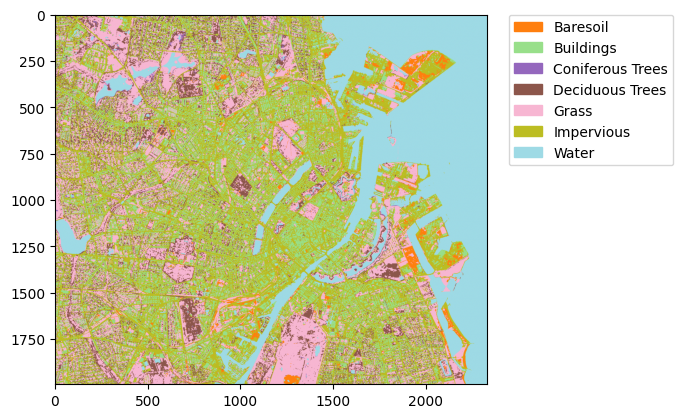

In [2]:
f = "/teamspace/studios/this_studio/eotorch/notebooks/lightning_logs/version_6/checkpoints/epoch=10-step=12672.ckpt"

SemanticSegmentationTask.predict_on_tif_file(
    tif_file_path="/teamspace/studios/this_studio/normalized/33UUB/20230419.tif",
    weights_path=f,
    patch_size=256,
    class_mapping=class_mapping,
    show_results=True,
    out_file_path="/teamspace/studios/this_studio/predictions/20230419_pred.tif",
)